In [111]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import FastICA
from pandas import DataFrame, Series
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import io

%matplotlib inline
np.set_printoptions(precision=3 , suppress= True)

In [33]:
#importing the file and defining the columns I am going to work with:
filePath = './mpra.txt'
columnsName = ['YYMMMDD', '_north(m)', 'sig_n(m)']
site = pd.read_csv(filePath, usecols = columnsName, delimiter = '\s+')
site

,YYMMMDD,_north(m),sig_n(m)
0,02AUG09,0.472504,0.001025
1,02AUG10,0.473255,0.001062
2,02AUG11,0.472202,0.001021
3,02AUG12,0.473231,0.001044
4,02AUG13,0.471035,0.001055
...,...,...,...
7554,24JAN02,0.834859,0.001039
7555,24JAN03,0.837236,0.001011
7556,24JAN04,0.836844,0.001017
7557,24JAN05,0.835170,0.001100


In [34]:
#changing the dtype of 'YYMMMDD':
site['YYMMMDD'] = pd.to_datetime(site['YYMMMDD'], format='%y%b%d')
site['YYMMMDD']

0      2002-08-09
1      2002-08-10
2      2002-08-11
3      2002-08-12
4      2002-08-13
          ...    
7554   2024-01-02
7555   2024-01-03
7556   2024-01-04
7557   2024-01-05
7558   2024-01-06
Name: YYMMMDD, Length: 7559, dtype: datetime64[ns]

In [35]:
#setting 'YYMMMDD' as index:
site.set_index('YYMMMDD', inplace = True)
site

,_north(m),sig_n(m)
YYMMMDD,,
2002-08-09,0.472504,0.001025
2002-08-10,0.473255,0.001062
2002-08-11,0.472202,0.001021
2002-08-12,0.473231,0.001044
2002-08-13,0.471035,0.001055
...,...,...
2024-01-02,0.834859,0.001039
2024-01-03,0.837236,0.001011
2024-01-04,0.836844,0.001017


In [55]:
#creating a new instance with a new period for the time series:
sitePeriodTime = site.loc['2002-08-09':'2024-01-06']
sitePeriodTime

,_north(m),sig_n(m)
YYMMMDD,,
2002-08-09,0.472504,0.001025
2002-08-10,0.473255,0.001062
2002-08-11,0.472202,0.001021
2002-08-12,0.473231,0.001044
2002-08-13,0.471035,0.001055
...,...,...
2024-01-02,0.834859,0.001039
2024-01-03,0.837236,0.001011
2024-01-04,0.836844,0.001017


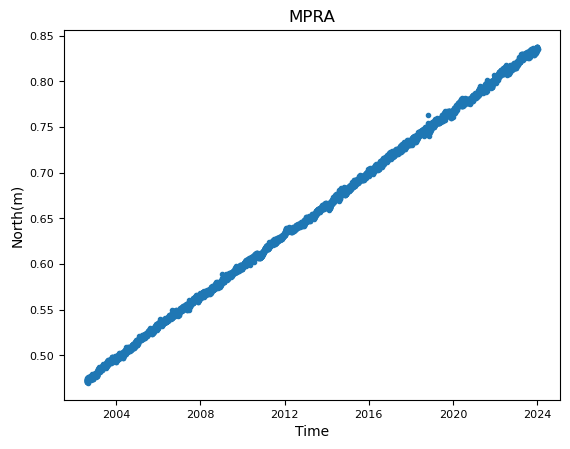

In [56]:
#checking the if the ts is stationarity for east:
plt.plot(sitePeriodTime.index, sitePeriodTime['_north(m)'], '.')
plt.title('MPRA')
plt.xlabel('Time')
plt.xticks(fontsize=8)
plt.ylabel('North(m)')
plt.yticks(fontsize=8)
plt.show()

In [57]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

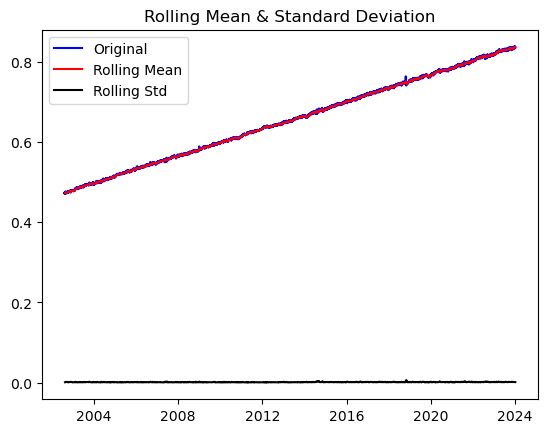

Results of Dickey-Fuller Test:
Test Statistic                   -0.480073
p-value                           0.895847
#Lags Used                       27.000000
Number of Observations Used    7531.000000
Critical Value (1%)              -3.431219
Critical Value (5%)              -2.861924
Critical Value (10%)             -2.566974
dtype: float64


In [58]:
test_stationarity(sitePeriodTime['_north(m)'])

In [68]:
tsLogN = np.log1p(sitePeriodTime['_north(m)'])
tsLogN

YYMMMDD
2002-08-09    0.386964
2002-08-10    0.387474
2002-08-11    0.386759
2002-08-12    0.387458
2002-08-13    0.385966
                ...   
2024-01-02    0.606968
2024-01-03    0.608262
2024-01-04    0.608049
2024-01-05    0.607137
2024-01-06    0.606997
Name: _north(m), Length: 7559, dtype: float64

In [70]:
tsLogN_df = pd.DataFrame(tsLogN, index=tsLogN.index)
tsLogN_df

,_north(m)
YYMMMDD,
2002-08-09,0.386964
2002-08-10,0.387474
2002-08-11,0.386759
2002-08-12,0.387458
2002-08-13,0.385966
...,...
2024-01-02,0.606968
2024-01-03,0.608262
2024-01-04,0.608049


In [71]:
tsLogDiffN = tsLogN - tsLogN.shift()
tsLogDiffN

YYMMMDD
2002-08-09         NaN
2002-08-10    0.000510
2002-08-11   -0.000715
2002-08-12    0.000699
2002-08-13   -0.001492
                ...   
2024-01-02   -0.000633
2024-01-03    0.001295
2024-01-04   -0.000213
2024-01-05   -0.000912
2024-01-06   -0.000140
Name: _north(m), Length: 7559, dtype: float64

In [72]:
tsLogDiffN.dropna(inplace = True)
tsLogDiffN

YYMMMDD
2002-08-10    0.000510
2002-08-11   -0.000715
2002-08-12    0.000699
2002-08-13   -0.001492
2002-08-14    0.001169
                ...   
2024-01-02   -0.000633
2024-01-03    0.001295
2024-01-04   -0.000213
2024-01-05   -0.000912
2024-01-06   -0.000140
Name: _north(m), Length: 7558, dtype: float64

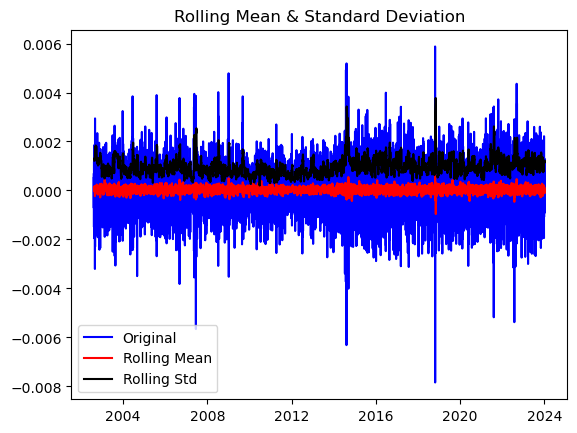

Results of Dickey-Fuller Test:
Test Statistic                  -22.806946
p-value                           0.000000
#Lags Used                       26.000000
Number of Observations Used    7531.000000
Critical Value (1%)              -3.431219
Critical Value (5%)              -2.861924
Critical Value (10%)             -2.566974
dtype: float64


In [73]:
test_stationarity(tsLogDiffN)

In [74]:
tsLogDiffN_df = pd.DataFrame(tsLogDiffN, index=tsLogDiffN.index)
tsLogDiffN_df

,_north(m)
YYMMMDD,
2002-08-10,0.000510
2002-08-11,-0.000715
2002-08-12,0.000699
2002-08-13,-0.001492
2002-08-14,0.001169
...,...
2024-01-02,-0.000633
2024-01-03,0.001295
2024-01-04,-0.000213


In [75]:
limiarZ = 1.0
tsLogDiffN_noOut = tsLogDiffN_df[(np.abs(tsLogDiffN_df-tsLogDiffN_df.mean()) 
                                              < limiarZ*tsLogDiffN_df.std())]
tsLogDiffN_noOut

,_north(m)
YYMMMDD,
2002-08-10,0.000510
2002-08-11,-0.000715
2002-08-12,0.000699
2002-08-13,NaN
2002-08-14,NaN
...,...
2024-01-02,-0.000633
2024-01-03,NaN
2024-01-04,-0.000213


In [121]:
#removing the rows with missing values
tsLogDiffN_noOut.dropna(inplace=True)
tsLogDiffN_noOut

,_north(m)
YYMMMDD,
2002-08-10,0.000510
2002-08-11,-0.000715
2002-08-12,0.000699
2002-08-15,0.000123
2002-08-16,-0.000534
...,...
2024-01-01,-0.000754
2024-01-02,-0.000633
2024-01-04,-0.000213


from statsmodels.tsa.seasonal import seasonal_decompose

#data frame before checking the outliers
decompositionN = seasonal_decompose(tsLogDiffN_df, period=365)
trendN = decompositionN.trend
seasonalN = decompositionN.seasonal
residualN = decompositionN.resid

plt.subplot(411) 
plt.plot(tsLogDiffN_df, label='Original') 
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(trendN, label='T') 
plt.legend(loc='best') 
plt.subplot(413) 
plt.plot(seasonalN,label='S') 
plt.legend(loc='best') 
plt.subplot(414) 
plt.plot(residualN, label='R') 
plt.legend(loc='best') 
plt.tight_layout()

#making a copy of the data 
tsLogDiffN_noOut2= tsLogDiffN_noOut

#replacing the missing values for the mean
tsLogDiffN_noOut2.fillna(tsLogDiffN_noOut2.mean(), inplace = True)


plt.subplot(411) 
plt.plot(tsLogDiffN_noOut, label='rem')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(tsLogDiffN_noOut2, label='rep') 
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(loc='best') 

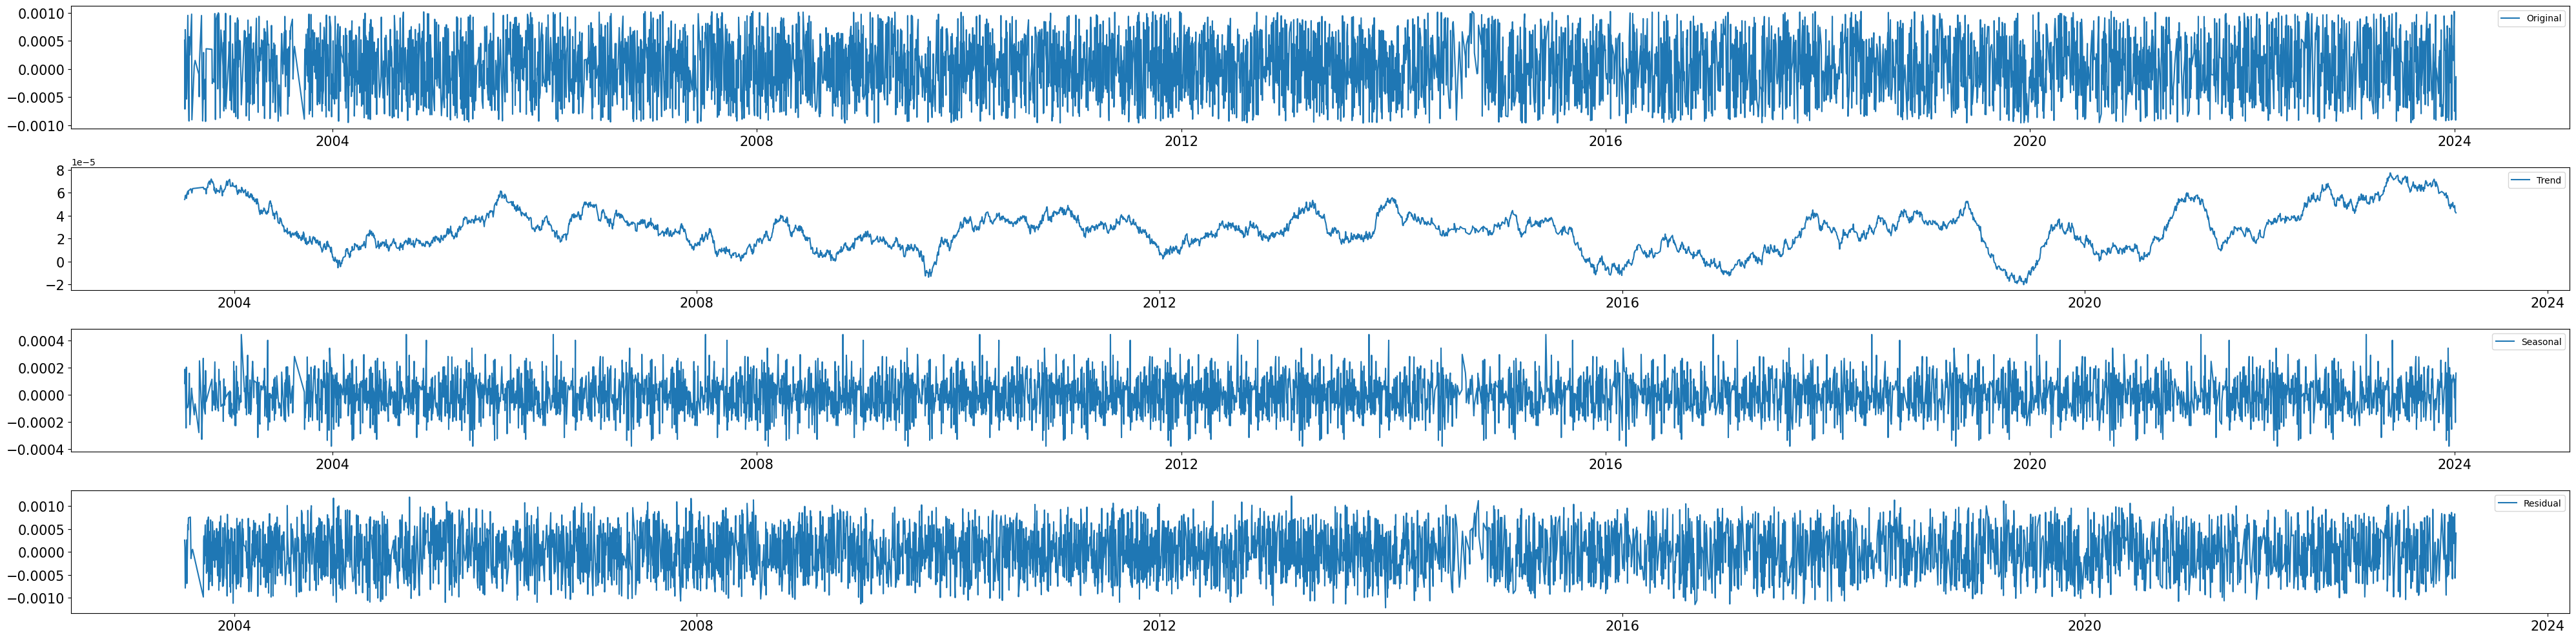

In [134]:
#data frame with outliers removed 
decompositionN_outRem = seasonal_decompose(tsLogDiffN_noOut, period=365)
trendN_outRem = decompositionN_outRem.trend
seasonalN_outRem = decompositionN_outRem.seasonal
residualN_outRem = decompositionN_outRem.resid

fig=plt.figure(figsize=(40,10))

plt.subplot(411) 
plt.plot(tsLogDiffN_noOut, label='Original') 
plt.legend(loc='best')
plt.xticks(fontsize=15)
#plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2014-01-15'))
plt.yticks(fontsize=15)

plt.subplot(412) 
plt.plot(trendN_outRem, label='Trend') 
plt.legend(loc='best') 
plt.xticks(fontsize=15)
#plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2014-01-15'))
plt.yticks(fontsize=15)

plt.subplot(413) 
plt.plot(seasonalN_outRem,label='Seasonal') 
plt.legend(loc='best')
plt.xticks(fontsize=15)
#plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2014-01-15'))
plt.yticks(fontsize=15)

plt.subplot(414) 
plt.plot(residualN_outRem, label='Residual') 
plt.legend(loc='best') 
plt.xticks(fontsize=15)
#plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2014-01-15'))
plt.yticks(fontsize=15)

plt.tight_layout()

fl = 'mpra_decomposition.svg'
f = io.BytesIO()
plt.savefig(fl, format="svg")

#data frame with outliers replaced (1086 rows)
decompositionN_outRep = seasonal_decompose(tsLogDiffN_noOut2, period=365)
trendN_outRep = decompositionN_outRep.trend
seasonalN_outRep = decompositionN_outRep.seasonal
residualN_outRep = decompositionN_outRep.resid

plt.subplot(411) 
plt.plot(tsLogDiffN_noOut2, label='Original') 
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(trendN_outRep, label='T') 
plt.legend(loc='best') 
plt.subplot(413) 
plt.plot(seasonalN_outRep,label='S') 
plt.legend(loc='best') 
plt.subplot(414) 
plt.plot(residualN_outRep, label='R') 
plt.legend(loc='best') 
plt.tight_layout()

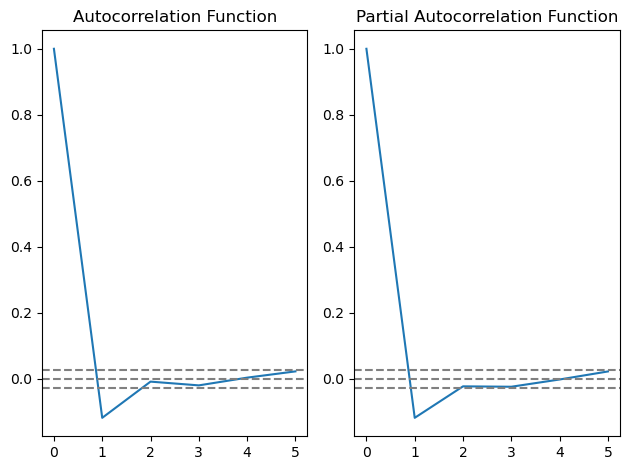

In [79]:
#ACF and PACF plots - rolling mean:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(tsLogDiffN_noOut, nlags=5)
lag_pacf = pacf(tsLogDiffN_noOut, nlags=5, method='ols')

#Plot ACF (q -> model MA): 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsLogDiffN_noOut)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsLogDiffN_noOut)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF (p -> model AR): 
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsLogDiffN_noOut)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsLogDiffN_noOut)),linestyle='--',color='gray') 
plt.title('Partial Autocorrelation Function') 
plt.tight_layout()

In [80]:
#converting the index to datetime
tsLogDiffN_df.index = pd.to_datetime(tsLogDiffN_df.index)
tsLogDiffN_noOut2.index = pd.to_datetime(tsLogDiffN_noOut2.index)
tsLogDiffN_noOut.index = pd.to_datetime(tsLogDiffN_noOut.index)
tsLogN_df.index = pd.to_datetime(tsLogN_df.index)

#making sure that the index is in order
tsLogDiffN_df.sort_index(inplace=True)
tsLogDiffN_noOut2.sort_index(inplace=True)
tsLogDiffN_noOut.sort_index(inplace=True)
tsLogN_df.sort_index(inplace=True)

#setting the frequency as daily
tsLogDiffN_df = tsLogDiffN_df.asfreq('D')
tsLogDiffN_noOut2 = tsLogDiffN_noOut2.asfreq('D')
tsLogDiffN_noOut = tsLogDiffN_noOut.asfreq('D')
tsLogN_df = tsLogN_df.asfreq('D')

In [81]:
from statsmodels.tsa.arima.model import ARIMA

In [82]:
tsLogDiffN_df.rename(columns={'_north(m)':'north(m)'}, inplace=True)

/Users/rafaelaoliveira/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


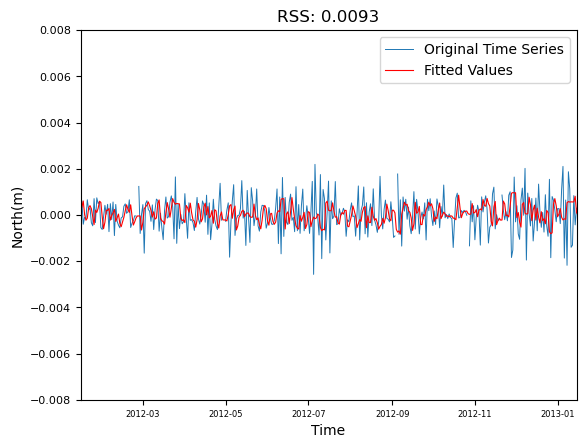

In [87]:
#model AR (Auto-Regressive) -> Plot PACF (p = 1)
modelN_AR = ARIMA(tsLogDiffN_noOut, order=(1, 1, 0))  
resultsN_AR = modelN_AR.fit()
plt.plot(tsLogDiffN_df,  label='Original Time Series', linewidth = 0.7)
plt.plot(resultsN_AR.fittedvalues, color='red', label='Fitted Values', linewidth= 0.8)

# Calculate Residual Sum of Squares (RSS)
residuals_AR = resultsN_AR.fittedvalues - tsLogDiffN_df['north(m)']
rss_AR = np.sum(residuals_AR**2, axis=0)

#Ensure rss is a scalar (float)
#rss_scalar = float(rss.iloc[0]) 

# Show the plot
plt.title(f'RSS: {rss_AR:.4f}')
plt.legend()
plt.xlabel('Time')
plt.xticks(fontsize=6)
plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2013-01-15'))
plt.ylabel('North(m)')
plt.ylim(-0.008,0.008)
plt.yticks(fontsize=8)
plt.show()

/Users/rafaelaoliveira/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


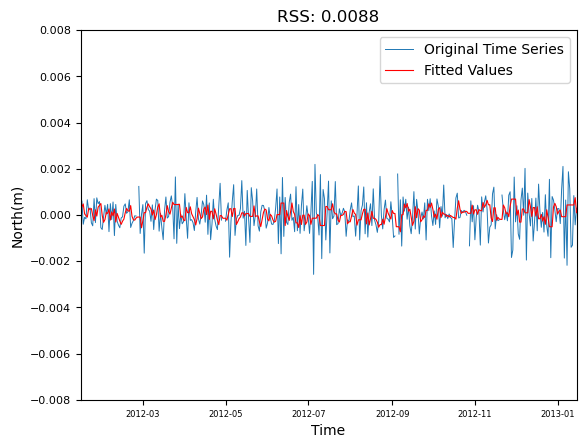

In [90]:
#model MA (Moving Averages) -> Plot ACF (q = 1)
model_MA = ARIMA(tsLogDiffN_noOut, order=(0, 1, 1))  
results_MA = model_MA.fit()  
plt.plot(tsLogDiffN_df, label='Original Time Series', linewidth = 0.7)
plt.plot(results_MA.fittedvalues, color='red', label='Fitted Values', linewidth= 0.8)

# Calculate Residual Sum of Squares (RSS)
residuals_MA = results_MA.fittedvalues - tsLogDiffN_df['north(m)']
rss_MA = np.sum(residuals_MA**2, axis=0)


plt.title(f'RSS: {rss_MA:.4f}')
plt.legend()
plt.xlabel('Time')
plt.xticks(fontsize=6)
plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2013-01-15'))
plt.ylabel('North(m)')
plt.ylim(-0.008,0.008)
plt.yticks(fontsize=8)
plt.show()

/Users/rafaelaoliveira/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


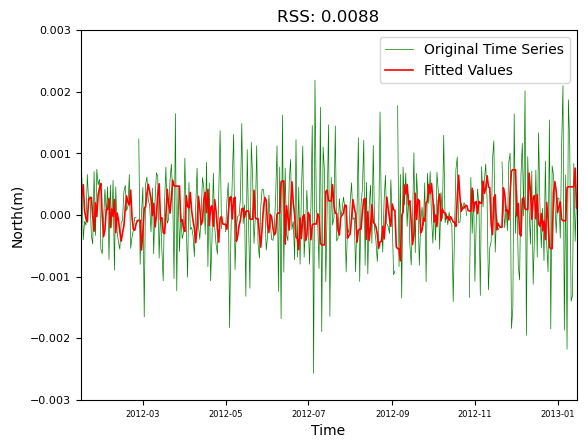

In [109]:
#combined - model ARIMA  p = 1 and q = 1:
#Auto-Regressive Integrated Moving Averages
model_ARIMA = ARIMA(tsLogDiffN_noOut, order=(1, 1, 1))  
results_ARIMA = model_ARIMA.fit()  
model1 = results_ARIMA.fittedvalues

plt.plot(tsLogDiffN_df, color='green', label='Original Time Series', linewidth = 0.5)
plt.plot(results_ARIMA.fittedvalues,color='red', label='Fitted Values', linewidth= 1.2)

# Calculate Residual Sum of Squares (RSS)
residuals_ARIMA = results_ARIMA.fittedvalues - tsLogDiffN_df['north(m)']
rss_ARIMA = np.sum(residuals_ARIMA**2, axis=0)

plt.title(f'RSS: {rss_ARIMA:.4f}')
plt.legend()
plt.xlabel('Time')
plt.xticks(fontsize=6)
plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2013-01-15'))
plt.ylabel('North(m)')
plt.ylim(-0.003,0.003)
plt.yticks(fontsize=8)
plt.show()

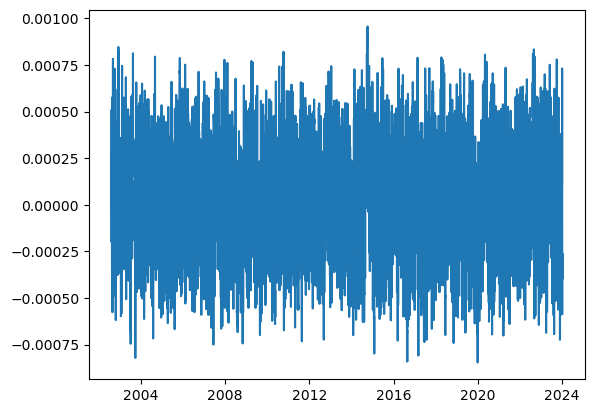

In [107]:
model_ARIMA2 = ARIMA(tsLogDiffN_noOut, order=(2, 1, 2))  
results_ARIMA2 = model_ARIMA2.fit()  

model2 = results_ARIMA2.fittedvalues

#ARIMA for outlier replaced
model_ARIMA_outDel = ARIMA(tsLogDiffN_noOut2, order=(1, 0, 1))
results_ARIMA_outDel = model_ARIMA_outDel.fit() 

#Plot rep: 
plt.subplot(121) 
plt.plot(tsLogDiffN_df, label='Original Time Series', linewidth = 0.4)
plt.plot(results_ARIMA.fittedvalues, color='red', label='Fitted Values', linewidth= 0.8)
plt.xlim(pd.Timestamp('2010-09-15'), pd.Timestamp('2011-03-15'))
plt.title('Outliers Replaced')

#Plot del: 
plt.subplot(122)
plt.plot(tsLogDiffN_df, label='Original Time Series', linewidth = 0.4)
plt.plot(results_ARIMA_outDel.fittedvalues, color='red', label='Fitted Values', linewidth= 0.8)
plt.xlim(pd.Timestamp('2010-09-15'), pd.Timestamp('2020-06-13'))
plt.title('Outliers Removed')
plt.tight_layout()

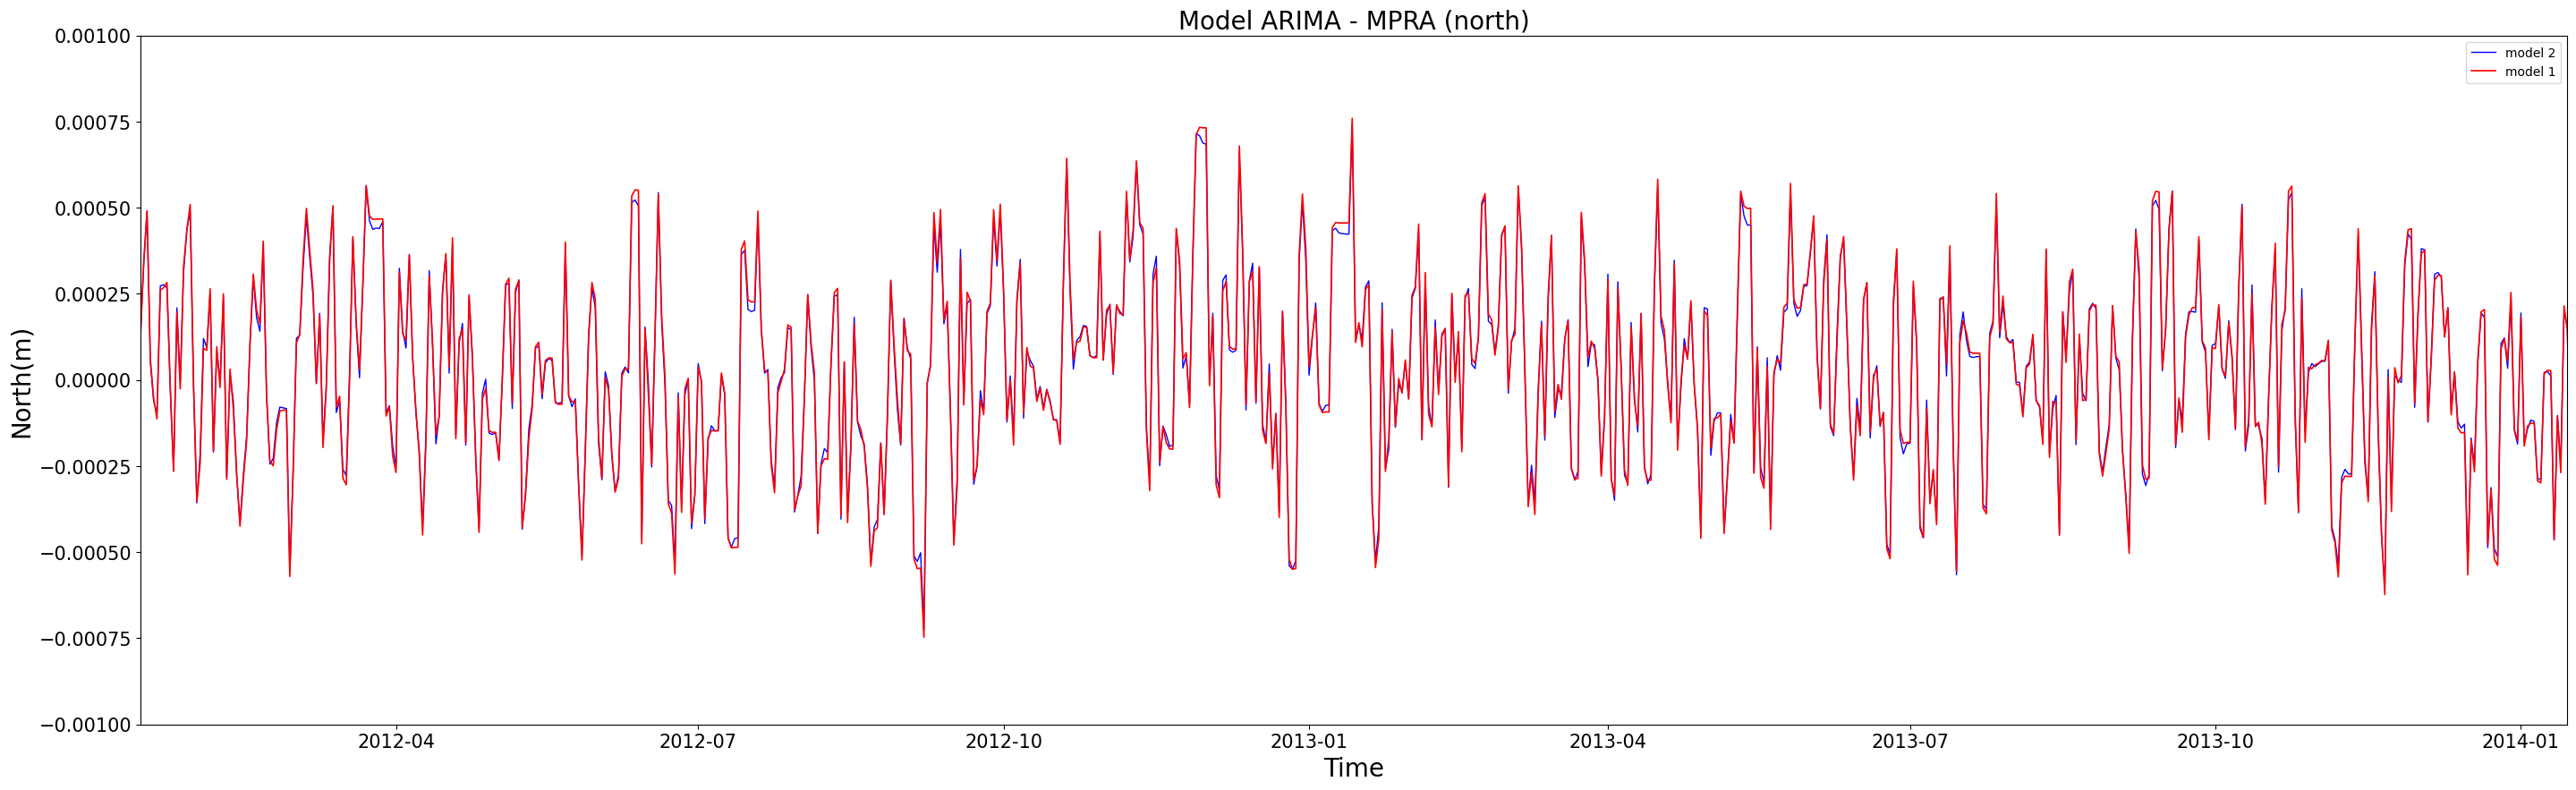

In [119]:
fig=plt.figure(figsize=(35,10))
#plt.plot(tsLogDiffN_df, color='green', label='Original Time Series', linewidth = 1.)
plt.plot(model2, color='blue', label='model 2', linewidth = 1.)
plt.plot(model1,color='red', label='model 1', linewidth= 1.2)

plt.title('Model ARIMA - MPRA (north)', fontsize=20)
plt.legend()
plt.xlabel('Time', fontsize=20)
plt.xticks(fontsize=15)
plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2014-01-15'))
plt.ylabel('North(m)', fontsize=20)
plt.ylim(-0.001,0.001)
plt.yticks(fontsize=15)
plt.legend(loc='best') 

fl = 'mpra_models_comparison.svg'
f = io.BytesIO()
plt.savefig(fl, format="svg")

plt.show()